# Our SAWYER Process
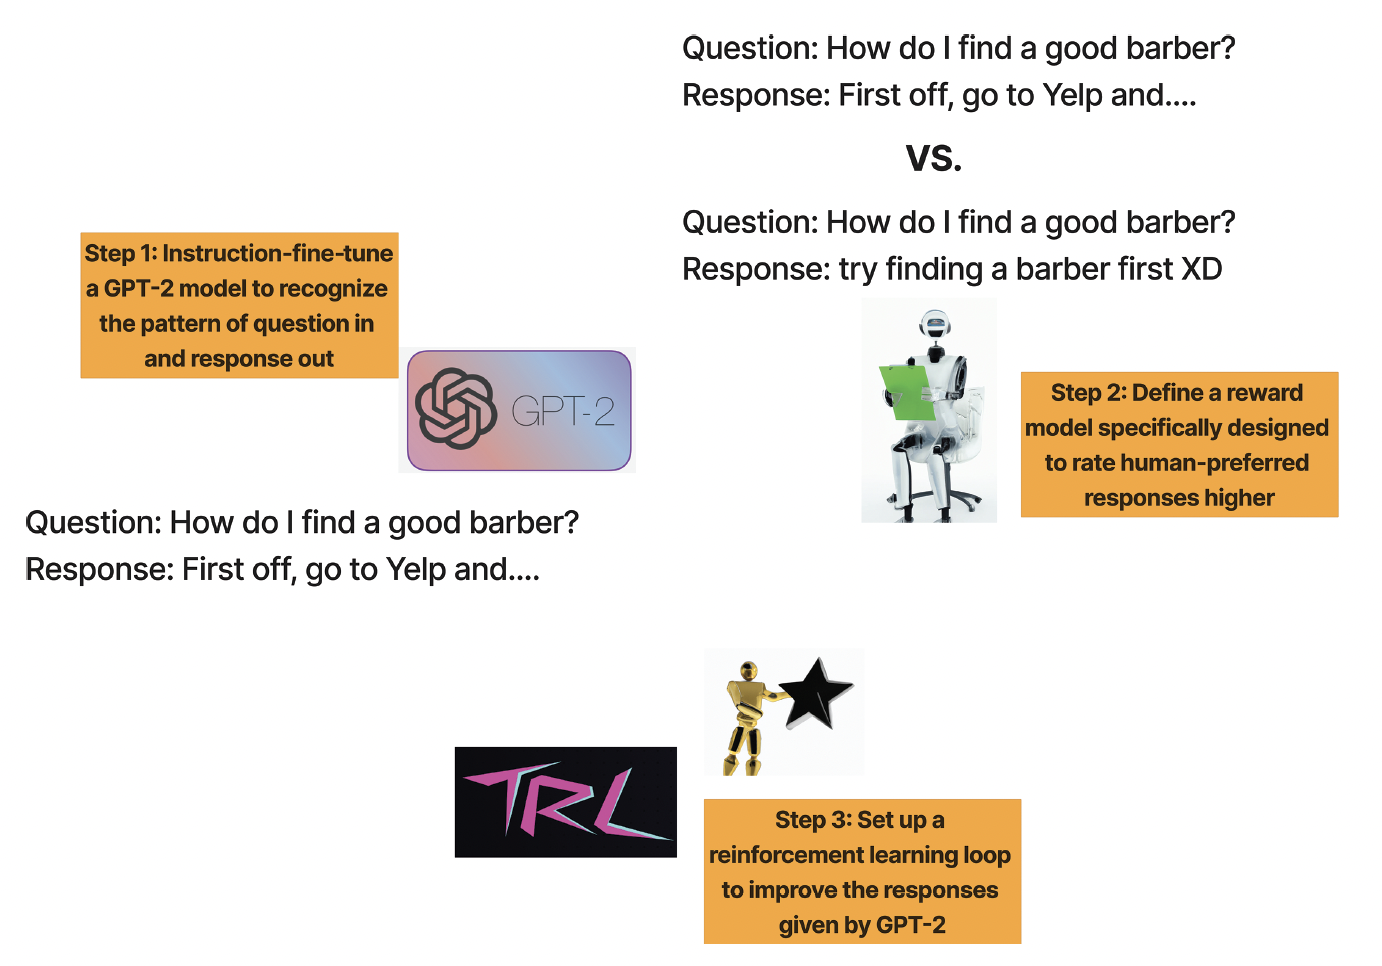

# Step 1: Instruction Fine-Tuning GPT-2

In [3]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, pipeline, \
                         AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from datasets import Dataset, load_dataset
import torch
import json

In [4]:
seed=42

In [6]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda")

device

device(type='cuda')

In [7]:
training_df = pd.read_csv('../data/chip2.csv')

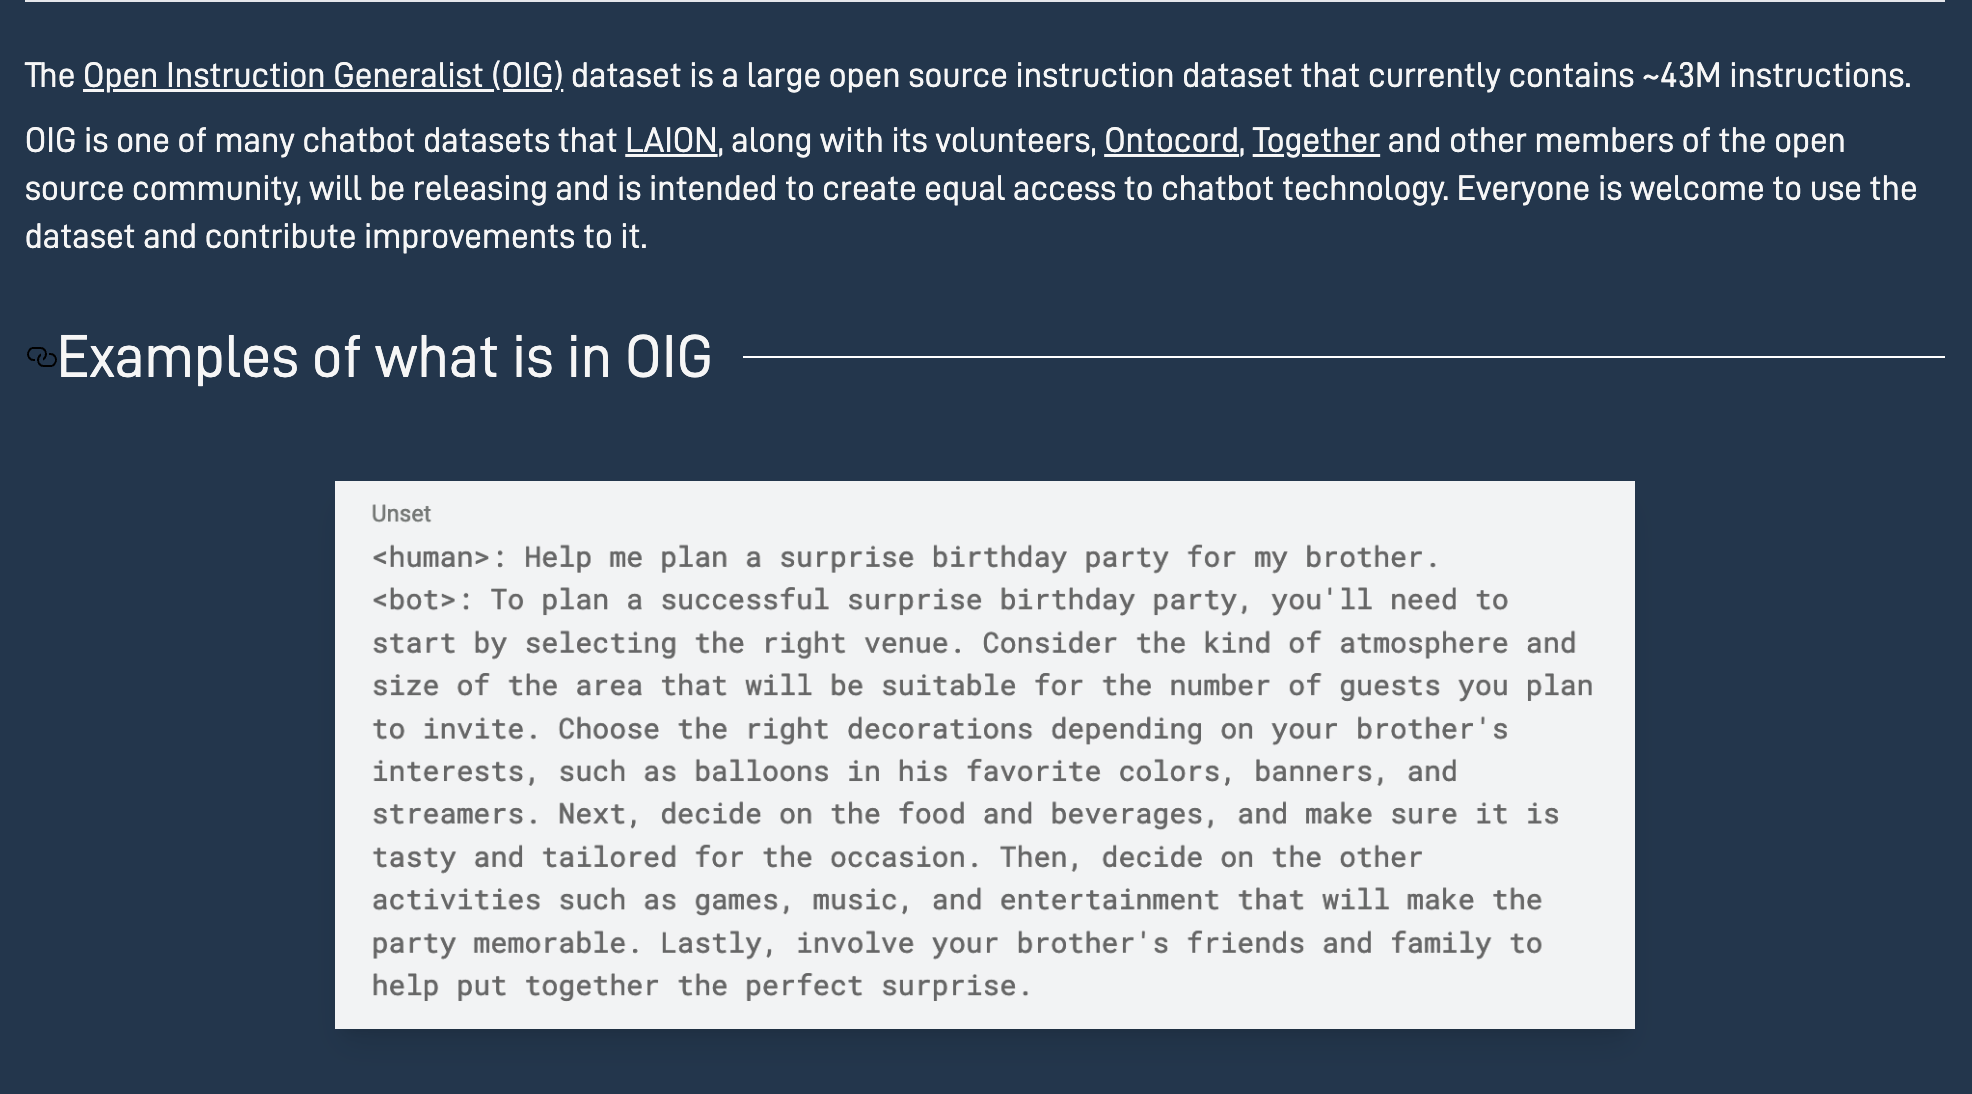

Find it [here](https://laion.ai/blog/oig-dataset/)

In [8]:
training_df.head()

,prompt,response,source
0,What is the name of the architect of the DeGol...,The architect of the DeGolyer House is Richard...,unified_chip2
1,Why did the US invade Iraq?,The US invaded Iraq in 2003 based on the belie...,unified_chip2
2,Can I make a typhoid vaccine?,"Yes, typhoid vaccines are available and can be...",unified_chip2
3,What's the best way to deal with an annoying c...,It's always best to approach the situation cal...,unified_chip2
4,Is it safe to drink alcohol if I have a histor...,"No, it is not safe to drink alcohol if you hav...",unified_chip2


In [7]:
print(training_df.iloc[798]['prompt'])
print(training_df.iloc[798]['response'])


Is there a list of all the U.S. presidents and when they served?
Yes, here is a list of all the U.S. presidents in chronological order and the dates they served:

George Washington (1789-1797)
John Adams (1797-1801)
Thomas Jefferson (1801-1809)
James Madison (1809-1817)
James Monroe (1817-1825)
John Quincy Adams (1825-1829)
Andrew Jackson (1829-1837)
Martin Van Buren (1837-1841)
William Henry Harrison (1841)
John Tyler (1841-1845)
James K. Polk (1845-1849)
Zachary Taylor (1849-1850)
Millard Fillmore (1850-1853)
Franklin Pierce (1853-1857)
James Buchanan (1857-1861)
Abraham Lincoln (1861-1865)
Andrew Johnson (1865-1869)
Ulysses S. Grant (1869-1877)
Rutherford B. Hayes (1877-1881)
James A. Garfield (1881)
Chester A. Arthur (1881-1885)
Grover Cleveland (1885-1889)
Benjamin Harrison (1889-1893)
Grover Cleveland (1893-1897)
William McKinley (1897-1901)
Theodore Roosevelt (1901-1909)
William Howard Taft (1909-1913)
Woodrow Wilson (1913-1921)
Warren G. Harding (1921-1923)
Calvin Coolidge (192

In [11]:
training_df.head()

,prompt,response,source
0,What is the name of the architect of the DeGol...,The architect of the DeGolyer House is Richard...,unified_chip2
1,Why did the US invade Iraq?,The US invaded Iraq in 2003 based on the belie...,unified_chip2
2,Can I make a typhoid vaccine?,"Yes, typhoid vaccines are available and can be...",unified_chip2
3,What's the best way to deal with an annoying c...,It's always best to approach the situation cal...,unified_chip2
4,Is it safe to drink alcohol if I have a histor...,"No, it is not safe to drink alcohol if you hav...",unified_chip2


In [23]:
training_df.shape

(112097, 3)

In [24]:
training_df['response'] = training_df['response'].map(lambda x: x.strip())
training_df['prompt'] = training_df['prompt'].map(lambda x: x.strip())

In [25]:
training_df = training_df.drop_duplicates(subset=['prompt'])  # drop duplicate prompts, just in case

In [26]:
training_df.shape

(112097, 3)

In [27]:
training_df.head(2)

,prompt,response,source
0,What is the name of the architect of the DeGol...,The architect of the DeGolyer House is Richard...,unified_chip2
1,Why did the US invade Iraq?,The US invaded Iraq in 2003 based on the belie...,unified_chip2


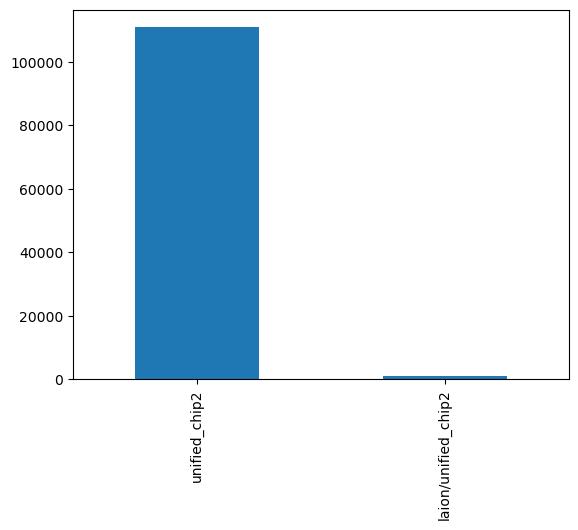

In [28]:
training_df['source'].value_counts().plot(kind='bar')

In [29]:
training_df.shape

(112097, 3)

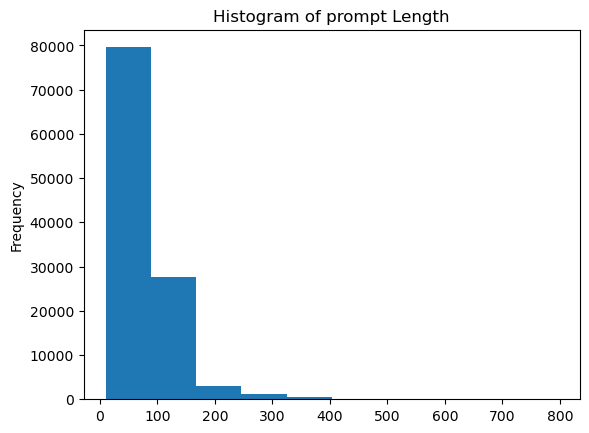

In [30]:
training_df['prompt'].str.len().plot(kind='hist', title='Histogram of prompt Length')

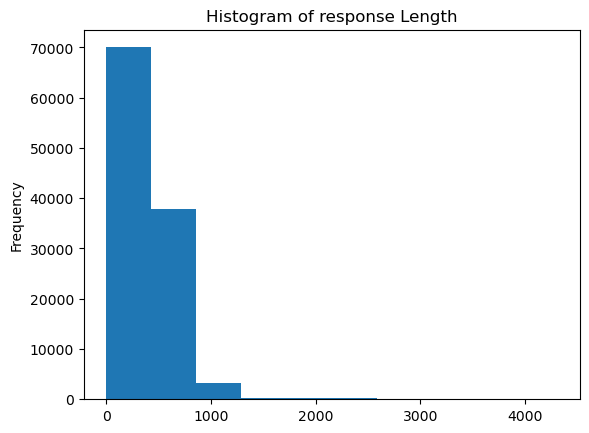

In [31]:
training_df['response'].str.len().plot(kind='hist', title='Histogram of response Length')

In [32]:
QUERY_KEY = "Question:"
RESPONSE_KEY = "Response:"
PAD_KEY = "<PAD>"


In [36]:

MODEL = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Adding new tokens to represent query, pad, and response. Many LLMs use reserved tokens.
tokenizer.add_special_tokens({"additional_special_tokens": [QUERY_KEY, RESPONSE_KEY, PAD_KEY]})
tokenizer.pad_token = PAD_KEY


model = AutoModelForCausalLM.from_pretrained(MODEL)
model.config.pad_token = PAD_KEY
model.resize_token_embeddings(len(tokenizer))


Embedding(50260, 768)

In [37]:
chip2_dataset = Dataset.from_pandas(training_df)

def preprocess(example):
    return tokenizer(QUERY_KEY+ ' ' + example['prompt'] + '\n'+RESPONSE_KEY+' '+example['response']+tokenizer.eos_token)

chip2_dataset = chip2_dataset.map(
    preprocess, batched=False, batch_size=1024, remove_columns=chip2_dataset.features.keys()
)

def filter_function(example):
    return len(example['input_ids']) <= 1024

chip2_dataset = chip2_dataset.filter(filter_function)


chip2_dataset = chip2_dataset.train_test_split(test_size=0.2, seed=seed)

  0%|          | 0/112097 [00:00<?, ?ex/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 1024). Running this sequence through the model will result in indexing errors


  0%|          | 0/113 [00:00<?, ?ba/s]

In [38]:
chip2_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 89676
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 22419
    })
})

In [46]:
print(tokenizer.decode(chip2_dataset['test']['input_ids'][13]))
print('-----')
print(tokenizer.decode(chip2_dataset['test']['input_ids'][14]))
print('-----')
print(tokenizer.decode(chip2_dataset['test']['input_ids'][63]))

Question: What is the name of the character played by Emily Blunt in the movie ‘The Young Victoria’?
Response: Queen Victoria<|endoftext|>
-----
Question: How is a blockchain ledger used?
Response: A blockchain ledger is primarily used for recording and verifying transactions in a secure and decentralized manner. Every participant in the network has a copy of the ledger, creating transparency and traceability of all transactions. It is commonly used in cryptocurrencies and other financial applications, but can also have uses in supply chain management, voting systems, and more.<|endoftext|>
-----
Question: Can you give me an overview of the elements of the periodic table?
Response: The periodic table is a tabular arrangement of chemical elements based on their atomic number, electron configuration, and chemical properties. It is divided into rows called periods and columns called groups. There are currently 118 known elements, each with its unique set of properties. The elements are or

In [40]:
len(chip2_dataset['test']['input_ids'][0])

102

In [41]:
f'{model.num_parameters():,}'

'124,442,112'

In [9]:
import wandb
# Set up Weights and Biases integration
wandb.init(project="sawyer")


In [23]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
print(torch.cuda.get_device_name(0))
if device.type == 'cuda':
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA TITAN X (Pascal)
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [24]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
    return_tensors="pt", pad_to_multiple_of=8
)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./sawyer_supervised_instruction",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=1,  # number of training epochs
    per_device_train_batch_size=2,  # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    gradient_accumulation_steps=16,  # steps for gradient accumulation
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    report_to="all",
    seed=seed,
    fp16=True,  # enable mixed precision training for my GPU
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=chip2_dataset['train'],
    eval_dataset=chip2_dataset['test'],
    data_collator=data_collator
)

trainer.evaluate()


In [25]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./sawyer",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=1,  # number of training epochs
    per_device_train_batch_size=2,  # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    gradient_accumulation_steps=16,  # steps for gradient accumulation
    logging_steps=50,
    learning_rate=2e-5,
    warmup_steps=100,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    report_to="all",
    seed=seed,
    fp16=True,  # enable mixed precision training for GPU
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=chip2_dataset['train'],
    eval_dataset=chip2_dataset['test'],
    data_collator=data_collator
)

trainer.evaluate()


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '



KeyboardInterrupt



In [ ]:
number_of_examples = len(chip2_dataset['train'])
per_device_train_batch_size = training_args.per_device_train_batch_size
gradient_accumulation_steps = training_args.gradient_accumulation_steps
num_train_epochs = training_args.num_train_epochs

effective_batch_size = per_device_train_batch_size * gradient_accumulation_steps
number_of_training_steps = (number_of_examples / effective_batch_size) * num_train_epochs

number_of_training_steps = int(number_of_training_steps / training_args.n_gpu)

print("Number of training steps:", number_of_training_steps)


In [ ]:
training_args.warmup_steps = int(.1 * number_of_training_steps)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model()

In [ ]:
tokenizer.save_pretrained("./sawyer/tokenizer/")


### Loss drops dramatically which is expected when we introduce new tokens

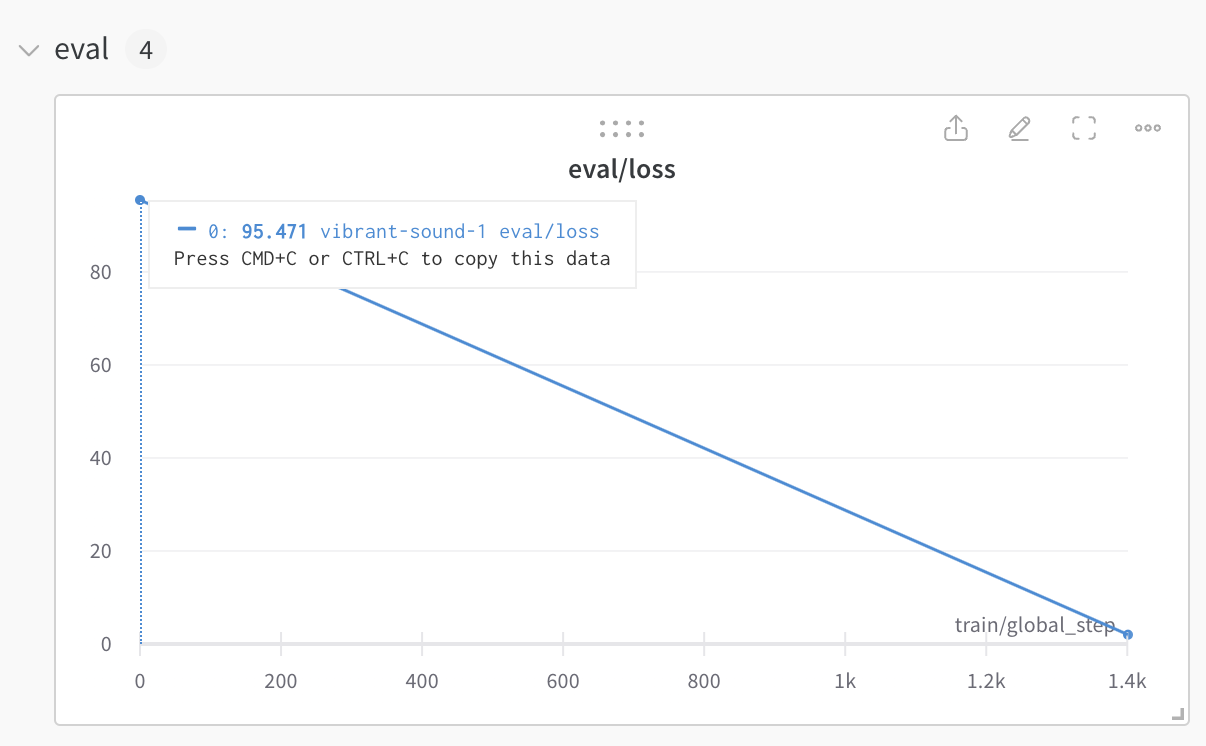